In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import matplotlib.cm as cm
from scipy.io import loadmat
import random
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

<IPython.core.display.Javascript object>


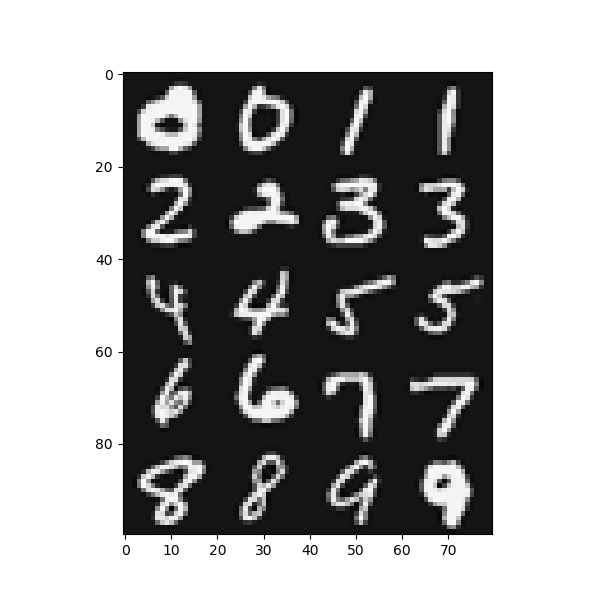

In [14]:
data = loadmat('data/Lab4/ex4data1.mat')
X_ex1=data["X"]
y_ex1=data["y"]
def display_images(X, y):
    def convert_image(image):
        cols, rows=20,20
        return image.reshape((cols, rows)).T
    nrows, ncols=5, 4
    indices_to_display=[]
    number_indixes=defaultdict(list)
    fig = plt.figure(figsize=(6,6))
    for (idx, value) in enumerate(y):
        number_indixes[value[0]].append(idx)
    for (value, idxes) in number_indixes.items():
        indices_to_display.extend(random.sample(idxes, 2))
    full_image=np.zeros((nrows*20, ncols*20))
    image_idx=0
    for i in range(1, nrows+1):
        for j in range(1, ncols+1):
            full_image[(i-1)*20:i*20, (j-1)*20:j*20]=convert_image(X[indices_to_display[image_idx], :])
            image_idx+=1
    plt.imshow(full_image,cmap = cm.Greys_r)
display_images(X_ex1, y_ex1)

weights = loadmat('data/Lab4/ex4weights.mat')
Theta1 = weights["Theta1"]
Theta2 = weights["Theta2"]
y_ex1=y_ex1.flatten()

In [5]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [6]:
class NetworkConfig:
    def __init__(self, hidden_layers_quantity, layers_sizes):
        self.hidden_layers_quantity=hidden_layers_quantity
        self.layers_sizes[i-1], =layers_sizes
        
    @property
    def input_size(self):
        return self.layers_sizes[0]
    
    @property
    def output_size(self):
        return self.layers_sizes[-1]
    
    @property
    def network_size(self):
        return self.hidden_layers_quantity+2
    
class SigmoidActivation:
    def calculate(self, X):
        return sigmoid(X)
    
    def calculate_derivative(self, X):
        return sigmoid(X)*(1-sigmoid(X))
    
class SME:
    def calculate(self, y, y_pred):
        assert y.shape==y_pred.shape
        if len(y.shape)==1:
            return np.sum(np.square(y-y_pred))
        else:
            return np.sum(np.sum(np.square(y-y_pred), axis=0))/y.shape[0]
        
classifier = MLPClassifier(solver="sgd")
classifier.hidden_layer_sizes = (40,)  
classifier.activation = "logistic"
classifier.fit(X_ex1, y_ex1.flatten())

        
class CrossEntropyCost:
    def calculate(self, y, y_pred):
        assert y.shape==y_pred.shape
        if len(y.shape)==1:
            return -np.sum(y*np.log(y_pred))
        else:
            return -np.sum(y*np.log(y_pred), axis=0)
    
class FeedForwardNeuralNetwork:
    def __init__(self, network_config, weights, biases, activation_functions, cost_func, grad_step=0.01, eps=0.01, reg_strength=0.5):
        self.network_config=network_config
        assert len(activation_functions)==network_config.network_size-1
        self.activation_functions=[None]+activation_functions
        assert len(weights)==network_config.network_size-1
        self.weights=[None]+weights
        assert len(biases)==network_config.network_size-1
        self.biases=[None]+biases
        self.neurons_inputs=None
        self.activation_values=None
        self.eps=eps
        self.reg_strength=reg_strength
        self.cost_func=cost_func
        
    @classmethod
    def with_random_weights(cls, network_config, activation_f_cls=SigmoidActivation, cost_f_cls=CrossEntropyCost):
        activation_funs=[activation_f_cls() for i in range(network_config.network_size-1)]
        weights=[]
        for prev_sz, next_sz in zip(network_config.layers_sizes[:-1], network_config.layers_sizes[1:]):
            weights.append(np.random.rand(prev_sz, next_sz))
        return cls(network_config, np.array(weights), activation_funs, cost_f_cls())
        
    def fit(self, X, y):
        prev_cost=-10*self.eps
        while True:
            random_idx=0
            output=self.forward_propagation(X[random_idx, :])
            errors=self.backward_propagation(output, y[random_idx, :].T)
            weight_derivatives=self.calculate_weight_derivatives
            biases_derivatives=self.calculate_biases_derivatives()
            for l in range(1, self.network_config):
                self.weights[l]=self.weights[l]-self.grad_step*weight_derivatives[l]-self.grad_step*self.reg_strength*self.weights
                self.biases[l]=self.biases[l]-self.grad_step*self.biases[l]
            current_cost=self.calculate_cost_value(X, y)
            if np.fabs(current_cost-prev_cost)<self.eps:
                break
            else:
                prev_cost=current_cost            
        
    def forward_propagation(self, X):
        assert X.shape==(self.network_config.input_size, )
        self.neurons_inputs=[None]*self.network_config.network_size
        self.activation_values=[None]*self.network_config.network_size
        self.activation_values[0]=X
        for i in range(1, self.network_config.network_size):
            neuron_inputs=np.matmul(self.weights[i], self.activation_values[i-1])+self.biases[i]
            self.neurons_inputs[i]=neuron_inputs
            activation_f=self.activation_functions[i]
            acitvation_value=activation_f.calculate(neuron_inputs)
            self.activation_values[i]=acitvation_value
        return self.activation_values[self.network_config.network_size-1]
    
    def calculate_cost_value(self, X, y):
        y_pred=self.forward_propagation(X)
        reg_value=self.reg_strength/2*np.sum(np.array([np.sum(np.square(layer_weights) for layer_weights in self.weights[1:])]))
        return self.cost_func.calculate(y, y_pred)+reg_strength*reg_value
    
    def backward_propagation(self, output, y):
        self.errors=[None]*self.network_config.network_size
        activation_f=self.activation_functions[-1]
        self.errors[-1]=(output-y)*activation_f.calculate_derivative(self.activation_inputs[-1])
        for i in reversed(range(1, self.network_config.network_size-1)):
            activation_f=self.activation_functions[i]
            derivative_value=activation_f.calculate_derivative(self.activation_inputs[i])
            self.errors[i]=np.multiply(np.matmul(self.weights[i+1].T, errors[i+1]), derivative_value)
        return errors
    
    def calculate_biases_derivatives(self):
        return self.errors
    
    def calculate_weight_derivatives(self):
        for l in range(1, self.network_config.network_size):
            prev_size, current_size=self.network_config.layers_sizes[l-1], self.network_config.layers_sizes[l]
            derivatives=np.zeros((current_size, prev_size))
            for i in current_size:
                for j in prev_size:
                    derivatives[i, j]=self.activation_values[l-1][j]*self.errors[l][i]
        return derivatives
    
    def predict(self, X):
        if len(X.shape)==1:
            predicted_probs=np.array([self.forward_propagation(X)])
        else:
            predicted_probs=np.array([self.forward_propagation(x) for x in X])
        predicted_classes=np.zeros((X.shape[0], self.network_config.output_size))
        for i in range(X.shape[0]):
            class_idx=np.argmax(predicted_probs[i, :])
            predicted_classes[i, class_idx]=1
        return predicted_classes
    
    def calculate_w_derivative_eps(X, y, layer_num, i, j, eps=0.001):
        orig_value=self.weights[layer_num][i, j]
        self.weights[layer_num][i, j]-=eps
        cost_min_eps=self.calculate_cost_value(X, y)
        self.weights[layer_num][i, j]+=2*eps
        cost_plus_eps=self.calculate_cost_value(X, y)
        weights[layer_num][i, j]=orig_value
        return (cost_plus_eps-cost_min_eps)/2*eps

D:\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [64]:
biases1=Theta1[:, 0]
biases2=Theta2[:, 0]
weights=[
    Theta1[:, 1:],
    Theta2[:, 1:]
]
activation_functions=[
    SigmoidActivation(),
    SigmoidActivation()
]
cost_func=CrossEntropyCost()
biases=[
    biases1,
    biases2
]
network_config=NetworkConfig(hidden_layers_quantity=1, layers_sizes=np.array([400, 25, 10]))
feed_forward_nn=FeedForwardNeuralNetwork(network_config, weights, biases, activation_functions, cost_func)
predicted_classes=feed_forward_nn.predict(X_ex1)
classifier = FeedForwardNeuralNetwork()
classifier.fit(X_ex1, y_ex1.flatten())

In [66]:
def calculate_accuracy(y_predicted, y_exp):
    assert y_predicted.shape==y_exp.shape
    correct_answers=0
    for (pred_class, exp_class) in zip(y_predicted, y_exp):
        if np.all(pred_class==exp_class):
            correct_answers+=1
    return correct_answers/y_exp.shape[0]
one_hot_encoder=OneHotEncoder(categories='auto')
one_hot_encoder.fit(y_ex1)
y_ex1_one_hot=one_hot_encoder.transform(y_ex1)
nn_accuracy=calculate_accuracy(predicted_classes, y_ex1_one_hot)
print(f"Neural network accuracy: {nn_accuracy}")
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_ex1, y_ex1.flatten())
print("Logistic regression accuracy: "+str(clf.score(X_ex1, y_ex1)))

Neural network accuracy: 0.9752
Logistic regression accuracy: 0.9624


D:\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [19]:
def calculate_accuracy_per_class(y_predicted, y_exp):
    assert y_predicted.shape==y_exp.shape
    per_class_answers={
        class_label: 0 for class_label in set(y_exp.tolist())
    }
    for class_label in per_class_answers:
        correct_ansers=0
        for y_pred, y in zip(y_predicted, y_exp):
            if y_pred==class_label and y==class_label:
                correct_ansers+=1
        class_items_quantity=np.sum(y_exp==class_label)
        per_class_answers[class_label]=correct_ansers/class_items_quantity
    return per_class_answers

In [25]:
classifier.learning_rate_init = 1
classifier.fit(X_ex1, y_ex1)
y_predicted=classifier.predict(X_ex1)
for class_labe, accuracy in calculate_accuracy_per_class(y_predicted, y_ex1).items():
    print(f"Accuracy for {class_labe} is {accuracy}")

Accuracy for 1 is 1.0
Accuracy for 2 is 1.0
Accuracy for 3 is 1.0
Accuracy for 4 is 1.0
Accuracy for 5 is 1.0
Accuracy for 6 is 1.0
Accuracy for 7 is 1.0
Accuracy for 8 is 1.0
Accuracy for 9 is 1.0
Accuracy for 10 is 1.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_ex1, y_ex1, test_size=0.2, random_state=42)

In [38]:
classifier.fit(X_train, y_train)
y_predicted=classifier.predict(X_test)
for class_labe, accuracy in calculate_accuracy_per_class(y_predicted, y_test).items():
    print(f"Accuracy for {class_labe} is {accuracy}")

Accuracy for 1 is 0.9523809523809523
Accuracy for 2 is 0.9142857142857143
Accuracy for 3 is 0.9058823529411765
Accuracy for 4 is 0.9042553191489362
Accuracy for 5 is 0.9693877551020408
Accuracy for 6 is 0.9489795918367347
Accuracy for 7 is 0.9196428571428571
Accuracy for 8 is 0.9259259259259259
Accuracy for 9 is 0.9099099099099099
Accuracy for 10 is 0.990990990990991


<IPython.core.display.Javascript object>


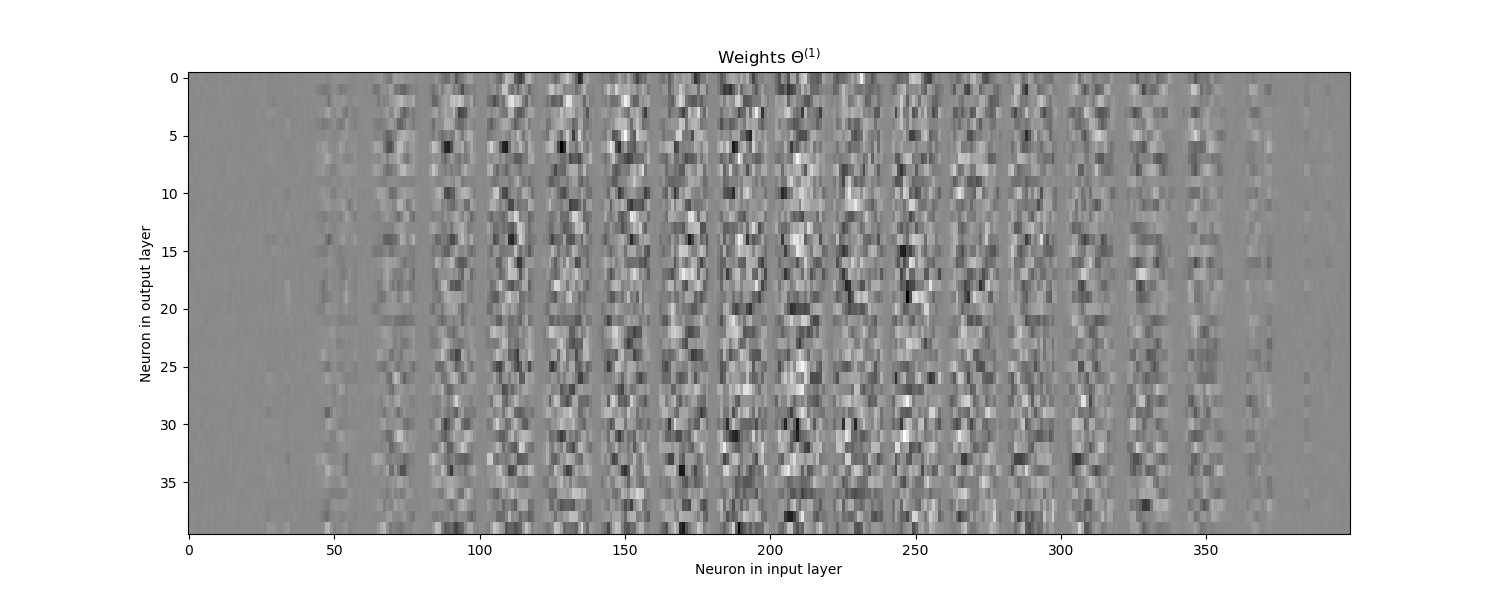

Text(0, 0.5, 'Neuron in output layer')

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(classifier.coefs_[0]), cmap=plt.get_cmap("gray"), aspect="auto")
ax.set_title("Weights $\Theta^{(1)}$")
ax.set_xlabel("Neuron in input layer")
ax.set_ylabel("Neuron in output layer")

<IPython.core.display.Javascript object>


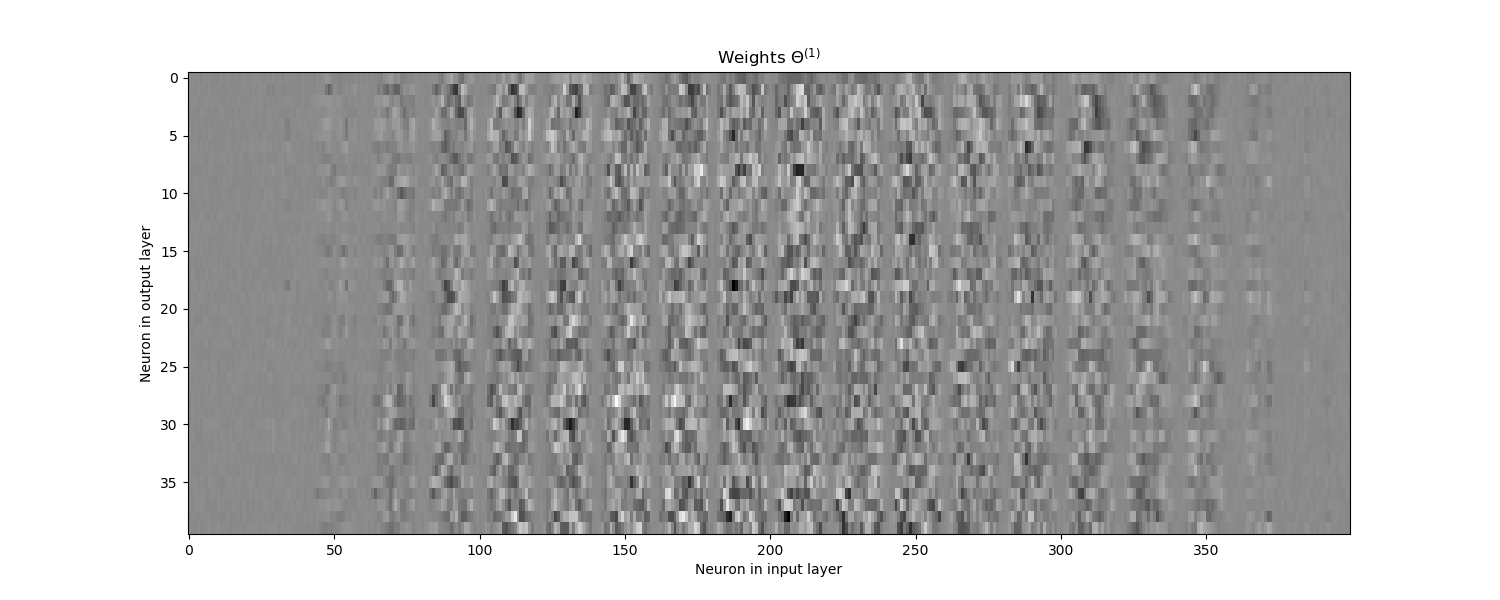

Text(0, 0.5, 'Neuron in output layer')

In [43]:
classifier.alpha=0.01
classifier.fit(X_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(classifier.coefs_[0]), cmap=plt.get_cmap("gray"), aspect="auto")
ax.set_title("Weights $\Theta^{(1)}$")
ax.set_xlabel("Neuron in input layer")
ax.set_ylabel("Neuron in output layer")

<IPython.core.display.Javascript object>


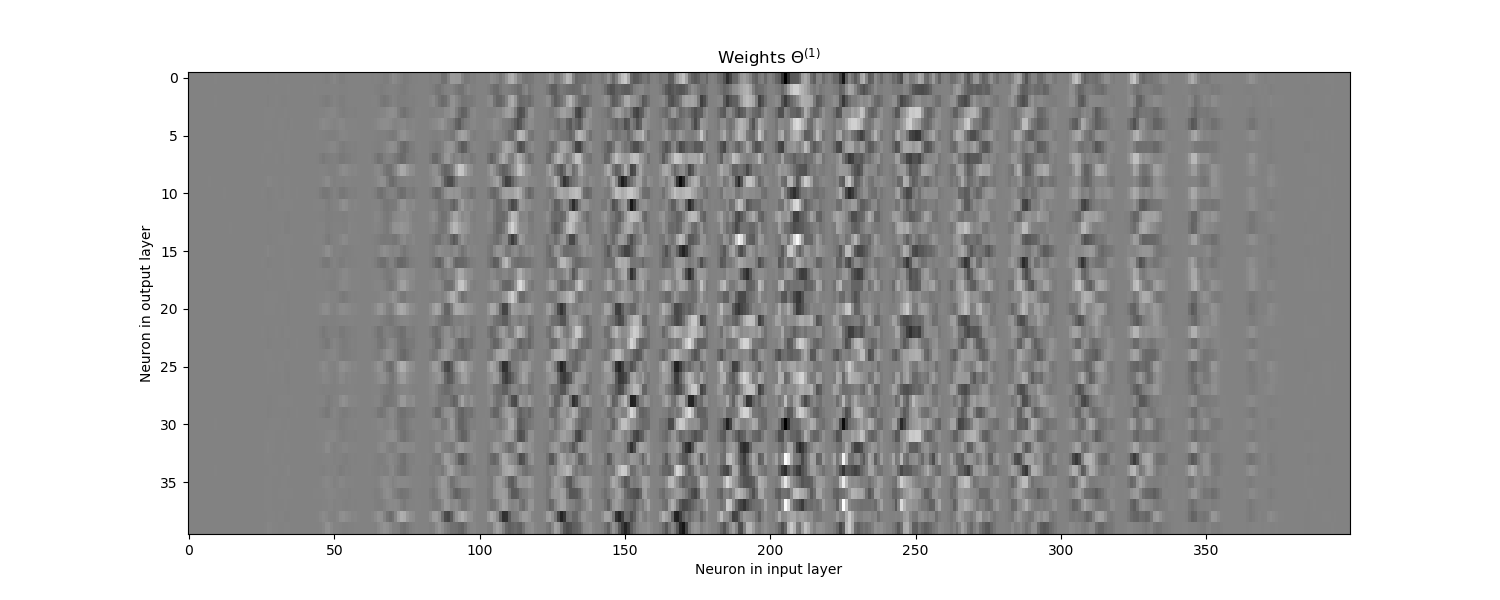

Text(0, 0.5, 'Neuron in output layer')

In [44]:
classifier.alpha=1
classifier.fit(X_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(classifier.coefs_[0]), cmap=plt.get_cmap("gray"), aspect="auto")
ax.set_title("Weights $\Theta^{(1)}$")
ax.set_xlabel("Neuron in input layer")
ax.set_ylabel("Neuron in output layer")

<IPython.core.display.Javascript object>


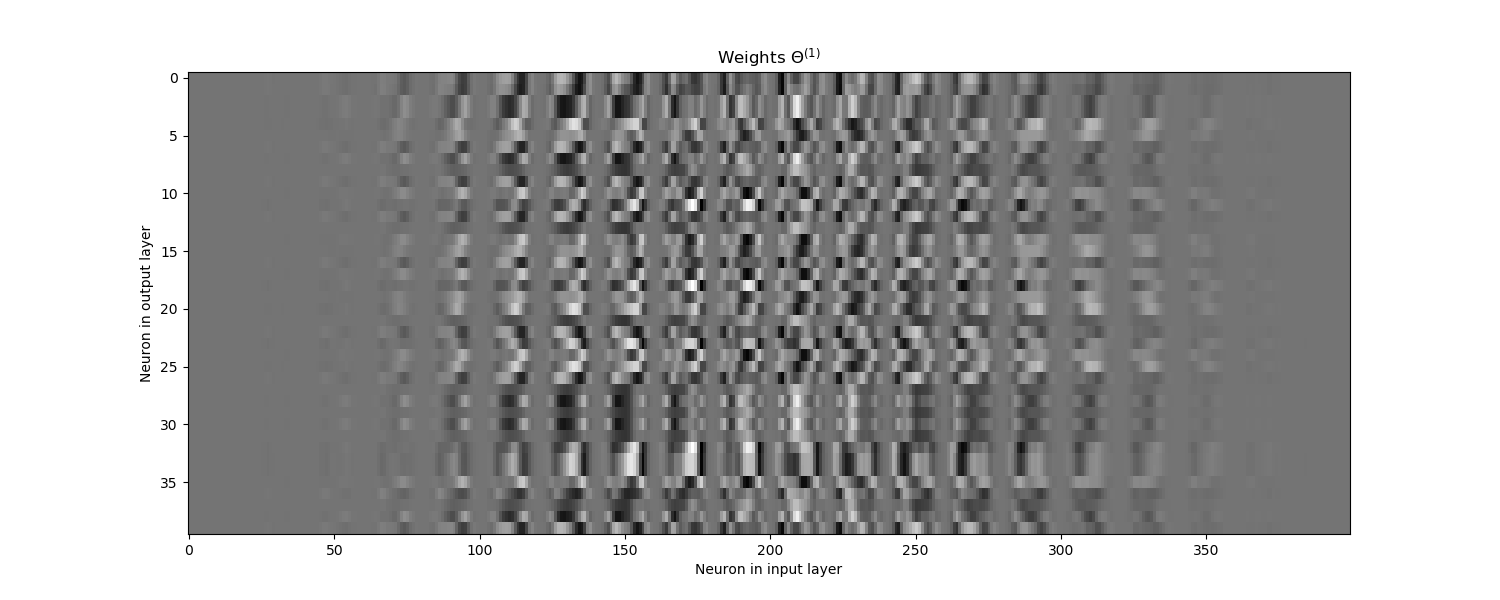

Text(0, 0.5, 'Neuron in output layer')

In [45]:
classifier.alpha=10
classifier.fit(X_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(classifier.coefs_[0]), cmap=plt.get_cmap("gray"), aspect="auto")
ax.set_title("Weights $\Theta^{(1)}$")
ax.set_xlabel("Neuron in input layer")
ax.set_ylabel("Neuron in output layer")

<IPython.core.display.Javascript object>


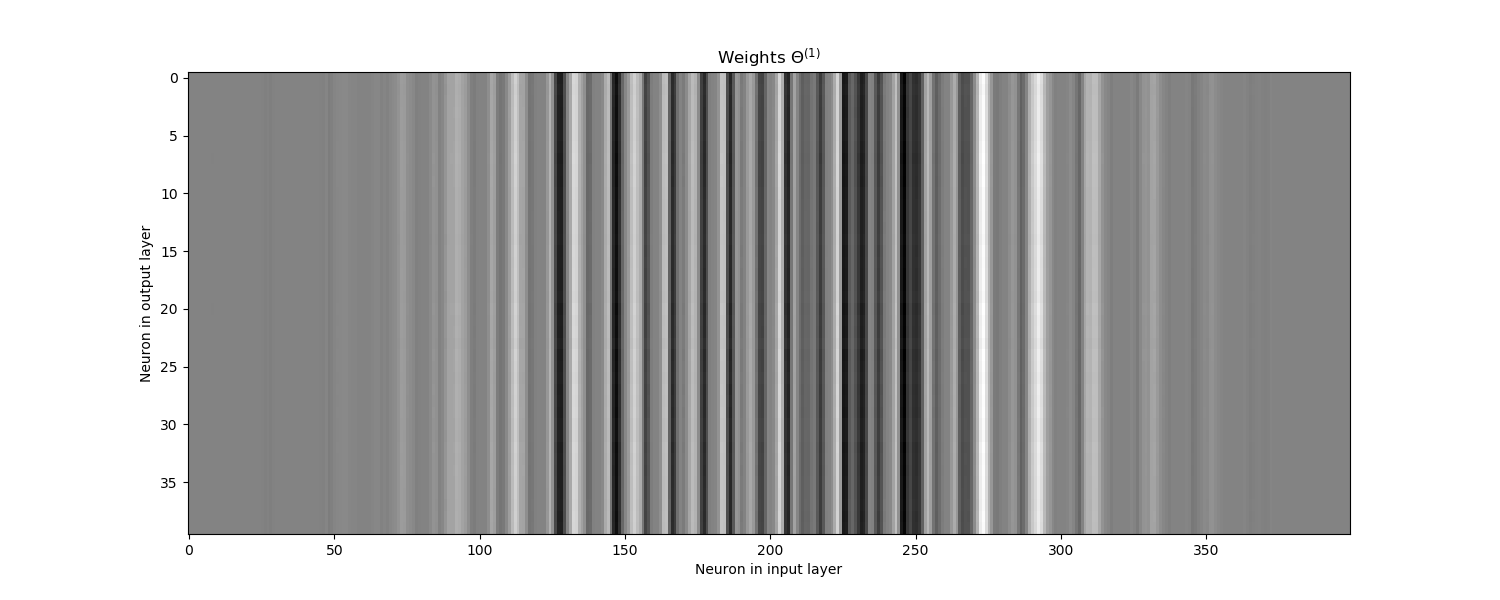

Text(0, 0.5, 'Neuron in output layer')

In [46]:
classifier.alpha=100
classifier.fit(X_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(classifier.coefs_[0]), cmap=plt.get_cmap("gray"), aspect="auto")
ax.set_title("Weights $\Theta^{(1)}$")
ax.set_xlabel("Neuron in input layer")
ax.set_ylabel("Neuron in output layer")